# Combined Simulation
This is a combined simulation of the P-wave and the S-wave. 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import math
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Simulation Area Parameter
NX, NY = 200, 200  #Grid size
XMIN, XMAX = 0.0, 2000.0  
YMIN, YMAX = 0.0, 2000.0  

# Animation Plot Parameter
PLOT_EVERY = 5  

In [3]:
# For Laplacian Approximation using FDM
DX = (XMAX - XMIN) / NX  # Spatial step (m)
DT = 0.001  # Time step (s)
NT = 900  

# Density model (kg/m³)
# For real world Earth structure, this is not supposed to be 
# constant because the Earth is not homogeneous or 
# anisotropic (properties vary based on direction)
RHO = np.ones((NX, NY)) * 1000.0

In [4]:
# Damping or Absorbing Boundary
ABL_WIDTH = 20 #grid point on simulation area's edge for absorbing
damping = np.ones((NX, NY)) 

# pressure on top and bottom get scaled down from 1.0 to 0.9
damping[:ABL_WIDTH, :] = np.linspace(0.9, 1.0, ABL_WIDTH)[:, np.newaxis]
damping[-ABL_WIDTH:, :] = np.linspace(1.0, 0.9, ABL_WIDTH)[:, np.newaxis]

# preserve the strongest damping when overlapping in left and right edge
damping[:, :ABL_WIDTH] = np.minimum(damping[:, :ABL_WIDTH], np.linspace(0.9, 1.0, ABL_WIDTH))
damping[:, -ABL_WIDTH:] = np.minimum(damping[:, -ABL_WIDTH:], np.linspace(1.0, 0.9, ABL_WIDTH))

In [5]:
# Seismic source (Ricker wavelet at center)
def ricker_wavelet(t, f0=20.0):
    return (1.0 - 2.0*(np.pi*f0*t)**2) * np.exp(-(np.pi*f0*t)**2)

source_x, source_y = NX//4, NY//2  # Source position
source_times = np.arange(NT) * DT # Time values

# Pressure amplitude
# The peak will occur on t which is source_times-0.1 or in
# 0.1 seconds instead right at t=0, so that it is smoother
source_amp = ricker_wavelet(source_times - 0.1, f0=20.0) * 1e6  

### P-Wave Parameters and Simulation

In [6]:
# Wave speed model (m/s) - Simple one layer model
VP = np.ones((NX, NY)) * 3000.0  # Base velocity (rock)

phi = np.zeros((NX, NY))  # Pressure field (current)
psi = np.zeros((NX, NY))  # Pressure field (previous)
vx = np.zeros((NX, NY))  # x-component of particle velocity
vy = np.zeros((NX, NY))  # y-component of particle velocity

In [8]:
def update_pwave(n):
    """Update the wave field for one time step"""
    global phi, psi, vx, vy
    
    # Add pressure injection/amplitude (S) to pressure field
    if n < len(source_amp):
        phi[source_x, source_y] += source_amp[n]
    
    # Update particle velocities (vx, vy)
    # vx[1:-1, 1:-1] -= (DT/RHO[1:-1, 1:-1]) * (phi[2:, 1:-1] - phi[:-2, 1:-1]) / (2*DX)
    # vy[1:-1, 1:-1] -= (DT/RHO[1:-1, 1:-1]) * (phi[1:-1, 2:] - phi[1:-1, :-2]) / (2*DX)
    
    # Update pressure field based on the final p_{i,j}^{n+1} formula
    phi_new = phi.copy()
    phi_new[1:-1, 1:-1] = (
        2*phi[1:-1, 1:-1] - psi[1:-1, 1:-1] +
        (VP[1:-1, 1:-1]**2 * DT**2 / DX**2) * (
            
            phi[2:, 1:-1] + phi[:-2, 1:-1] +
            phi[1:-1, 2:] + phi[1:-1, :-2] -
            4*phi[1:-1, 1:-1]
        )
    )
    # apply damping
    phi_new *= damping

    # Update fields
    psi = phi.copy()
    phi = phi_new.copy()

### S-Wave Parameters and Simulation

In [9]:
VS = np.ones((NX, NY)) * 1500.0  # shear wave velocity
MU = RHO * VS**2 
ux = np.zeros((NX, NY))  # x-component of displacement
uy = np.zeros((NX, NY))  # y-component of displacement
ux_prev = np.zeros((NX, NY))  # Previous time step
uy_prev = np.zeros((NX, NY))  # Previous time step

In [10]:
def update_swave(n):
    """Update the wave field for one time step for SV-waves"""
    global ux, uy, ux_prev, uy_prev
    
    # Add source (vertical force)
    if n < len(source_amp):
        uy[source_x, source_y] += source_amp[n] * DT**2 / RHO[source_x, source_y]
    
    # Calculate spatial derivatives
    dux_dx = np.zeros_like(ux)
    dux_dy = np.zeros_like(ux)
    duy_dx = np.zeros_like(uy)
    duy_dy = np.zeros_like(uy)
    
    # Central differences for derivatives
    dux_dx[1:-1, 1:-1] = (ux[2:, 1:-1] - ux[:-2, 1:-1]) / (2*DX)
    dux_dy[1:-1, 1:-1] = (ux[1:-1, 2:] - ux[1:-1, :-2]) / (2*DX)
    duy_dx[1:-1, 1:-1] = (uy[2:, 1:-1] - uy[:-2, 1:-1]) / (2*DX)
    duy_dy[1:-1, 1:-1] = (uy[1:-1, 2:] - uy[1:-1, :-2]) / (2*DX)
    
    tau_xy = MU * (duy_dx + dux_dy)
    
    ux_new = np.zeros_like(ux)
    uy_new = np.zeros_like(uy)
    
    # x-component
    ux_new[1:-1, 1:-1] = (
        2*ux[1:-1, 1:-1] - ux_prev[1:-1, 1:-1] +
        (DT**2 / RHO[1:-1, 1:-1]) * (
            (tau_xy[1:-1, 2:] - tau_xy[1:-1, :-2]) / (2*DX)  # ∂τ_xy/∂y
        )
    )
    
    # y-component
    uy_new[1:-1, 1:-1] = (
        2*uy[1:-1, 1:-1] - uy_prev[1:-1, 1:-1] +
        (DT**2 / RHO[1:-1, 1:-1]) * (
            (tau_xy[2:, 1:-1] - tau_xy[:-2, 1:-1]) / (2*DX)  # ∂τ_xy/∂x
        )
    )
    
    ux_new *= damping
    uy_new *= damping
    
    ux_prev = ux.copy()
    uy_prev = uy.copy()
    ux = ux_new.copy()
    uy = uy_new.copy()

### Simulation

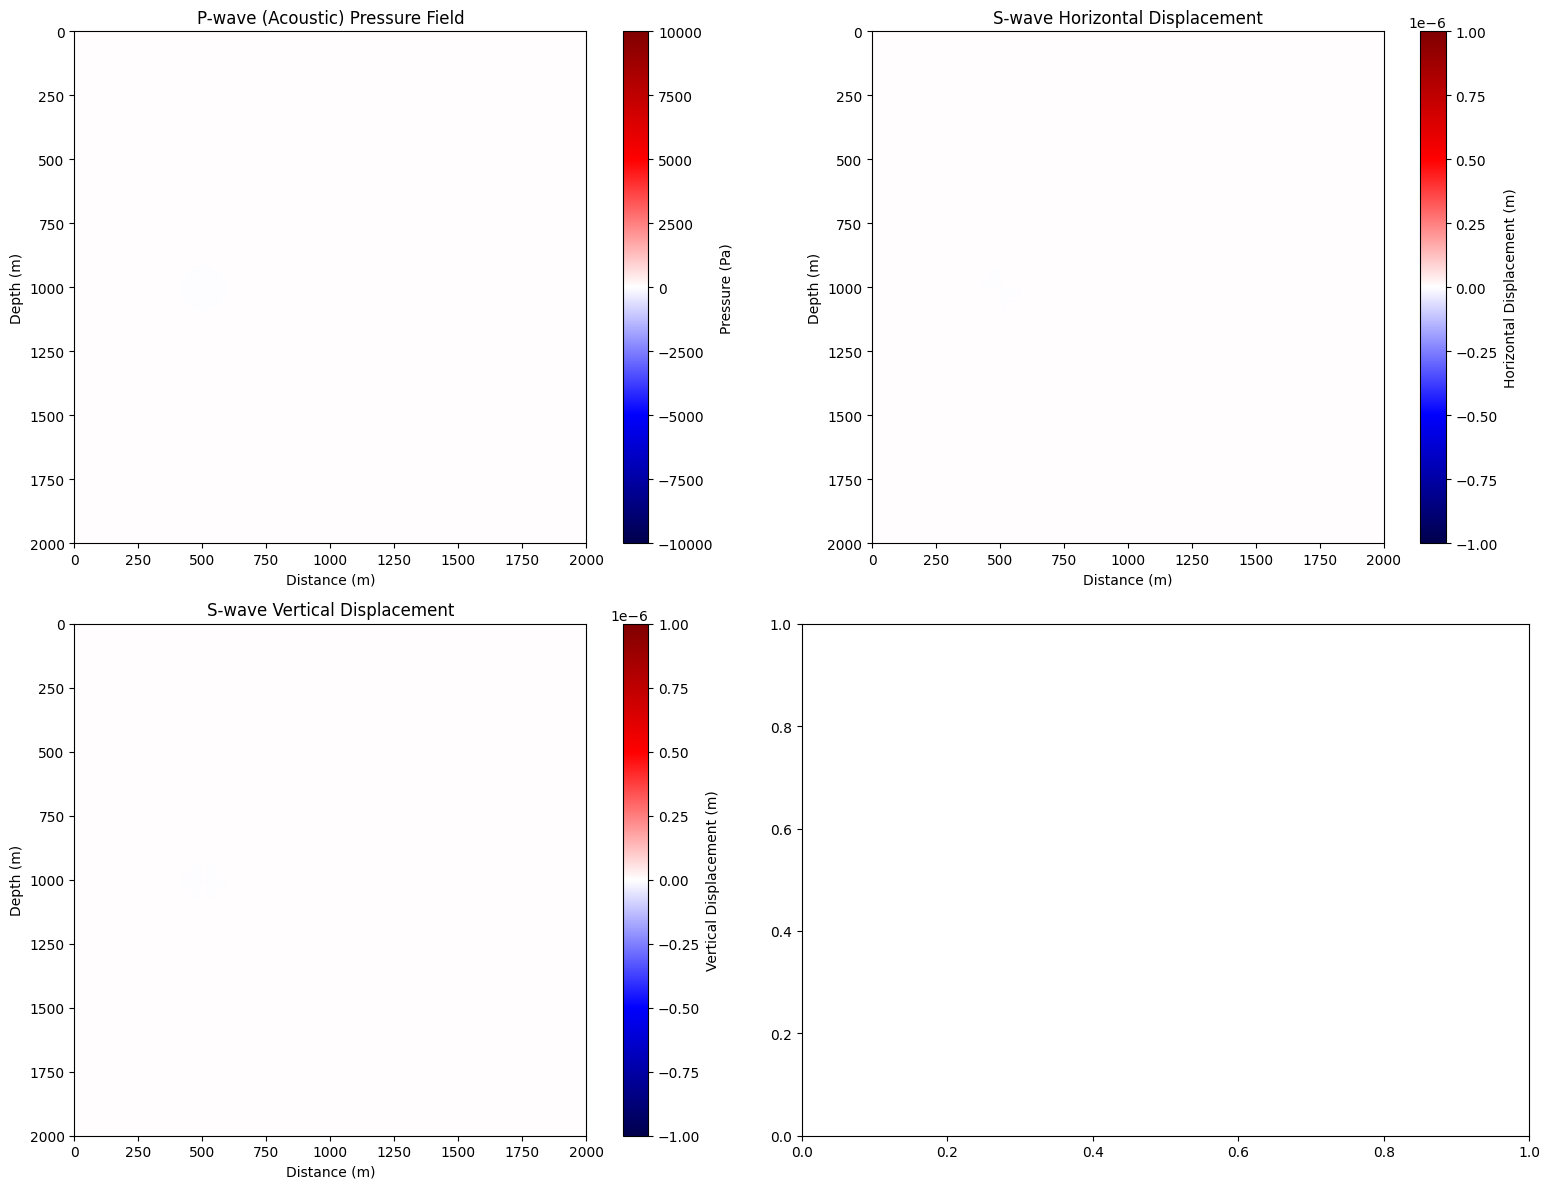

In [12]:
def create_plots():
    """Create figure with subplots for both simulations"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # P-wave plot
    img1 = ax1.imshow(phi.T, extent=[XMIN, XMAX, YMAX, YMIN], 
                     cmap='seismic', vmin=-1e4, vmax=1e4)
    plt.colorbar(img1, ax=ax1, label='Pressure (Pa)')
    ax1.set_title("P-wave (Acoustic) Pressure Field")
    ax1.set_xlabel("Distance (m)")
    ax1.set_ylabel("Depth (m)")
    
    # S-wave horizontal displacement
    img2 = ax2.imshow(ux.T, extent=[XMIN, XMAX, YMAX, YMIN], 
                     cmap='seismic', vmin=-1e-6, vmax=1e-6)
    plt.colorbar(img2, ax=ax2, label='Horizontal Displacement (m)')
    ax2.set_title("S-wave Horizontal Displacement")
    ax2.set_xlabel("Distance (m)")
    ax2.set_ylabel("Depth (m)")
    
    # S-wave vertical displacement
    img3 = ax3.imshow(uy.T, extent=[XMIN, XMAX, YMAX, YMIN], 
                     cmap='seismic', vmin=-1e-6, vmax=1e-6)
    plt.colorbar(img3, ax=ax3, label='Vertical Displacement (m)')
    ax3.set_title("S-wave Vertical Displacement")
    ax3.set_xlabel("Distance (m)")
    ax3.set_ylabel("Depth (m)")
    
    plt.tight_layout()
    return fig, (img1, img2, img3)

fig, (img1, img2, img3) = create_plots()

def update(frame):
    """Update function for animation"""
    for _ in range(PLOT_EVERY):
        update_pwave(frame * PLOT_EVERY + _)
        update_swave(frame * PLOT_EVERY + _)
    
    # Update P-wave plot
    img1.set_array(phi.T)
    
    # Update S-wave plots
    current_max = max(np.max(np.abs(ux)), np.max(np.abs(uy)))
    vlimit = current_max if current_max > 0 else 1e-6
    
    img2.set_array(ux.T)
    img2.set_clim(vmin=-vlimit, vmax=vlimit)
    
    img3.set_array(uy.T)
    img3.set_clim(vmin=-vlimit, vmax=vlimit)
    
    return [img1, img2, img3]

In [ ]:
ani = FuncAnimation(fig, update, frames=NT//PLOT_EVERY, 
                   interval=50, blit=True)

ffmpeg_writer = animation.FFMpegWriter(fps=20)
ani.save('combined_p_s_wave.mp4', writer=ffmpeg_writer)

plt.show()

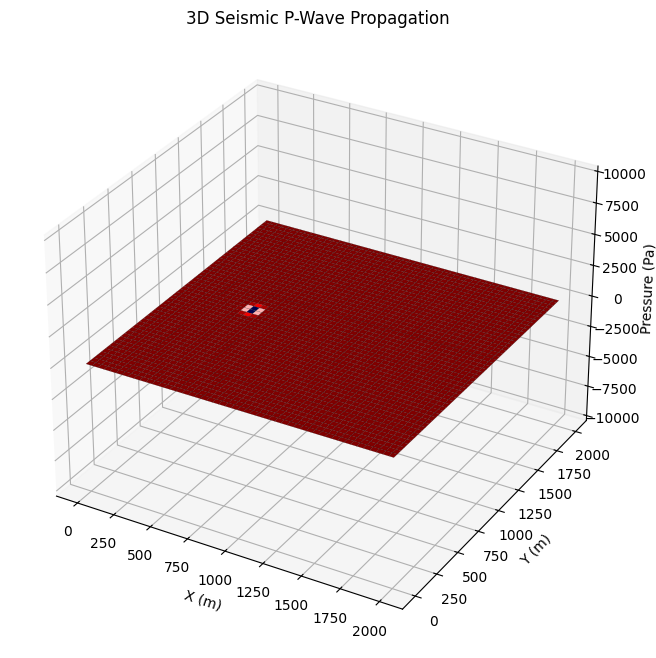

In [13]:
x = np.linspace(XMIN, XMAX, NX)
y = np.linspace(YMIN, YMAX, NY)
xx, yy = np.meshgrid(x, y)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim(-1e4, 1e4)
ax.set_title("3D Seismic P-Wave Propagation")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Pressure (Pa)")

# Initial surface
surface = [ax.plot_surface(xx, yy, phi.T, cmap='seismic', edgecolor='k', linewidth=0.1)]

def update_3d(frame):
    global phi
    for _ in range(PLOT_EVERY):
        update_pwave(frame * PLOT_EVERY + _)

    ax.clear()
    ax.set_zlim(-1e4, 1e4)
    ax.set_title(f"3D Seismic P-Wave - Time: {frame * DT * PLOT_EVERY:.3f} s")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Pressure (Pa)")
    surface[0] = ax.plot_surface(xx, yy, phi.T, cmap='seismic', edgecolor='k', linewidth=0.1)
    return surface

ani3d = FuncAnimation(fig, update_3d, frames=NT // PLOT_EVERY, interval=50, blit=False)
plt.show()

In [14]:
ffmpeg_writer = animation.FFMpegWriter(fps=20)
ani3d.save('combined_p_3d.mp4', writer=ffmpeg_writer)

#### Seismic Moment
Seismic moment $M_0$ is used to measure the size of an earthquake. Seismic moment can be analogued as how big the snap or the earthquake was. The formula of seismic moment is as below.
$$
M_0 = \mu \overline{u} S
$$
where
- $\mu$ is the shear modulus,
- $\overline{u}$ is the mean (over the area of the fracture) of the amount of displacement caused by the earthquake,
- $S$ is the area of the fracture.

In [14]:
# Rupture zone (ex: 10x10)
rupture_radius = 5
x_start, x_end = source_x - rupture_radius, source_x + rupture_radius
y_start, y_end = source_y - rupture_radius, source_y + rupture_radius

ux_rupture = ux[x_start:x_end, y_start:y_end] #x displacement in rupture zone
uy_rupture = uy[x_start:x_end, y_start:y_end] #y displacement in rupture zone
mu_rupture = MU[x_start:x_end, y_start:y_end] #mu in rupture zone

# total movement/displacement per point
u_magnitude = np.sqrt(ux_rupture**2 + uy_rupture**2)

# Average displacement (\overline{u})
u_avg = np.mean(u_magnitude)

# Average shear modulus (\mu)
mu_avg = np.mean(mu_rupture)

# Fracture area in m² (S)
# Each grid has physical size of DX, so the rupture area is a 10x10 square
# with the total area = (10 * DX) * (10 * DX) with 10 = 2 * rupture radius
S = ((2 * rupture_radius) * DX)**2  

M0 = mu_avg * u_avg * S
print(f"Seismic moment: {M0:.2e} Nm")

Seismic moment: 3.69e+09 Nm


#### Moment Magnitude and Energy Released
The moment magnitude $M_w$ is a measure of energy released by an earthquake. In other words, it is a measurement scale of the power of the earthquake. The moment magnitude is the new standard taht works for all earthquake. The old standard is the Richter scale where it is babsed on ground motion measured by seismograph. The formula of $M_w$ is 
$$
M_w = \frac{2}{3} \log{M_0} - 10.7 
$$
where $M_0$ is the seismic moment in dyne.cm.

The approximation of the energy released can be calculated using the moment magnitude. The formula is as below.
$$
\log{E} \approx 5.24 + 1.44 M_w
$$
where $M_w$ is the moment magnitude. $M_w$ is dimensionless.

In [17]:
# convert M0 to dyne.cm
M0_dynecm = M0 * 10000000 

# moment magnitude
Mw = (2/3) * math.log(M0_dynecm) - 10.7
print(f"Moment magnitude scale: {Mw}")

# energy released
E = 10**(5.24 + (1.44 * Mw))
print(f"Energy released: {E:.2e} J")

Moment magnitude scale: 14.731437462925633
Energy released: 2.84e+26 J
